In [1]:
import sys
import os

# Get the absolute path of the parent directory.
parent_dir = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))

# Add the parent directory to the system path to be able to import modules from 'lib.'
sys.path.append(parent_dir)

In [2]:
from IPython.display import HTML, Markdown as md
import itertools

from lib.memory import DSDM
from lib.utils import configs, inference, learning, preprocess, utils 

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy
import numpy as np
import random

import pandas as pd
import pathlib

import seaborn as sns

from transformers import AutoTokenizer, AutoModel

import torch
import torchhd as thd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F 

from tqdm import tqdm
# Type checking
from typing import List 

In [3]:
model_name = "bert-base-uncased"  # Has 12 layers
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [12]:
text = "'Albert Camus ( ,  ; ; 7 November 1913 – 4 January 1960) was a French philosopher, author, and journalist. He was awarded the 1957 Nobel Prize in Literature at the age of 44, the second-youngest recipient in history. His works include The Stranger, The Plague, The Myth of Sisyphus, The Fall, and The Rebel.\n\nCamus was born in French Algeria to Pieds Noirs parents. He spent his childhood in a poor neighbourhood and later studied philosophy at the University of Algiers. He was in Paris when the Germans invaded France during World War II in 1940. Camus tried to flee but finally joined the French Resistance where he served as editor-in-chief at Combat, an outlawed newspaper. After the war, he was a celebrity figure and gave many lectures around the world. He married twice but had many extramarital affairs. Camus was politically active; he was part of the left that opposed the Soviet Union because of its totalitarianism. Camus was a moralist and leaned towards anarcho-syndicalism. He was part of many organisations seeking European integration. During the Algerian War (1954–1962), he kept a neutral stance, advocating for a multicultural and pluralistic Algeria, a position that caused controversy and was rejected by most parties.\n\nPhilosophically, Camus\'s views contributed to the rise of the philosophy known as absurdism. He is also considered to be an existentialist, even though he firmly rejected the term throughout his lifetime.\n\nLife\n\nEarly years and education\n\nAlbert Camus was born on 7 November 1913 in a working-class neighbourhood in Mondovi (present-day Dréan), in French Algeria. His mother, Catherine Hélène Camus (née Sintès), was French with Balearic Spanish ancestry. His father, Lucien Camus, a poor French agricultural worker, died in the Battle of the Marne in 1914 during World War I. Camus never knew him. Camus, his mother and other relatives lived without many basic material possessions during his childhood in the Belcourt section of Algiers. He was a second-generation French in Algeria, a French territory from 1830 until 1962. His paternal grandfather, along with many others of his generation, had moved to Algeria for a better life during the first decades of the 19th century. Hence, he was called —a slang term for French who were born in Algeria—and his identity and his poor background had a substantial effect on his later life. Nevertheless, Camus was a French citizen and enjoyed more rights than Arab and Berber Algerians under indigénat. During his childhood, Camus developed a love for football and swimming.\n\nUnder the influence of his teacher Louis Germain, Camus gained a scholarship in 1924 to continue his studies at a prestigious lyceum (secondary school) near Algiers. In 1930, he was diagnosed with tuberculosis. Because it is a transmitted disease, he moved out of his home and stayed with his uncle Gustave Acault, a butcher, who influenced the young Camus. It was at that time that Camus turned to philosophy, with the mentoring of his philosophy teacher Jean Grenier. He was impressed by ancient Greek philosophers and Friedrich Nietzsche. During that time, he was only able to study part-time. To earn money, he took odd jobs: as a private tutor, car parts clerk, and assistant at the Meteorological Institute.\n\nIn 1933, Camus enrolled at the University of Algiers and completed his licence de philosophie (BA) in 1936; after presenting his thesis on Plotinus. Camus developed an interest in early Christian philosophers, but Nietzsche and Arthur Schopenhauer had paved the way towards pessimism and atheism. Camus also studied novelist-philosophers such as Stendhal, Herman Melville, Fyodor Dostoyevsky, and Franz Kafka. In 1933, he also met Simone Hié, then a partner of a friend of Camus, who would become his first wife.\n\nCamus played goalkeeper for the Racing Universitaire d\'Alger junior team from 1928 to 1930. The sense of team spirit, fraternity, and common purpose appealed to Camus enormously. In match reports, he was often praised for playing with passion and courage. Any football ambitions disappeared when he contracted tuberculosis at the age of 17. Camus drew parallels among football, human existence, morality, and personal identity. For him, the simplistic morality of football contradicted the complicated morality imposed by authorities such as the state and Church.\n\nFormative years\nIn 1934, aged 20, Camus was in a relationship with Simone Hié."
inputs = tokenizer(text, return_tensors="pt")

In [10]:
outputs = model(**inputs, output_attentions=True)
attention_matrix = outputs.attentions

RuntimeError: The size of tensor a (941) must match the size of tensor b (512) at non-singleton dimension 1

In [13]:
encoding = tokenizer.encode(text)
labels = tokenizer.convert_ids_to_tokens(encoding)

In [ ]:
encoding

In [16]:
pd.DataFrame(labels, columns=['token']).head(20)

,token
0,[CLS]
1,'
2,albert
3,cam
4,##us
5,(
6,","
7,;
8,;
9,7


In [215]:
#attention_matrix[0].shape # Layer

In [216]:
#attention_matrix[0][0].shape # Attention heads, Token-Token matrices

In [217]:
# token = 0

# token_scores = attention_matrix[0][0][0][token].cpu().detach().numpy() # First token

In [218]:
attention_matrix[11][0].shape

torch.Size([12, 10, 10])

In [219]:
attention_matrix[11].shape

torch.Size([1, 12, 10, 10])

In [220]:
len(attention_matrix[0][0][head].cpu().detach().numpy()[0])

10

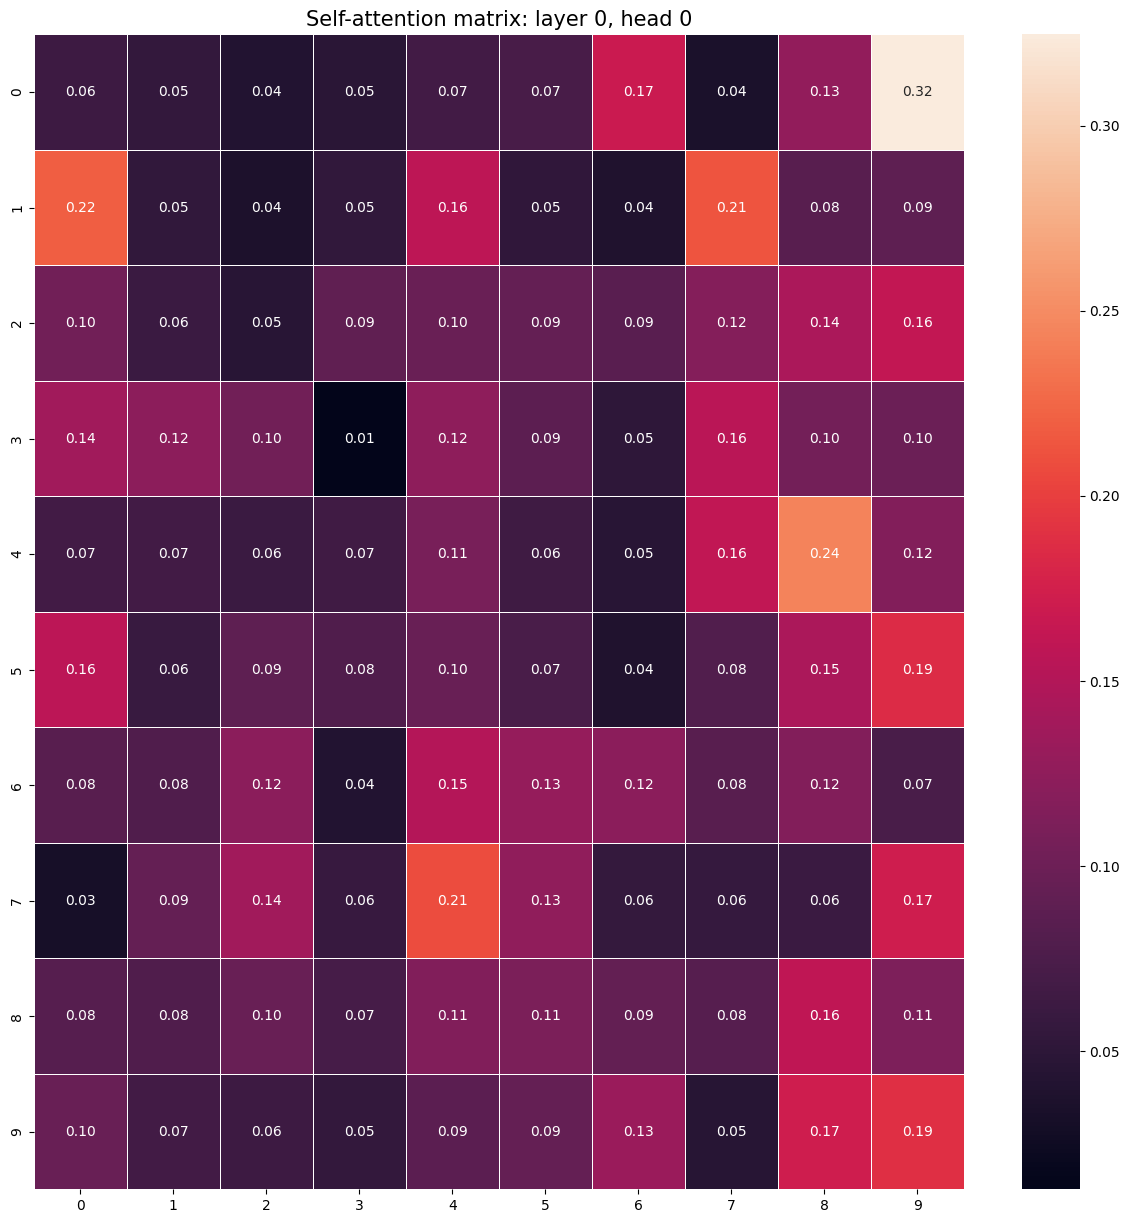

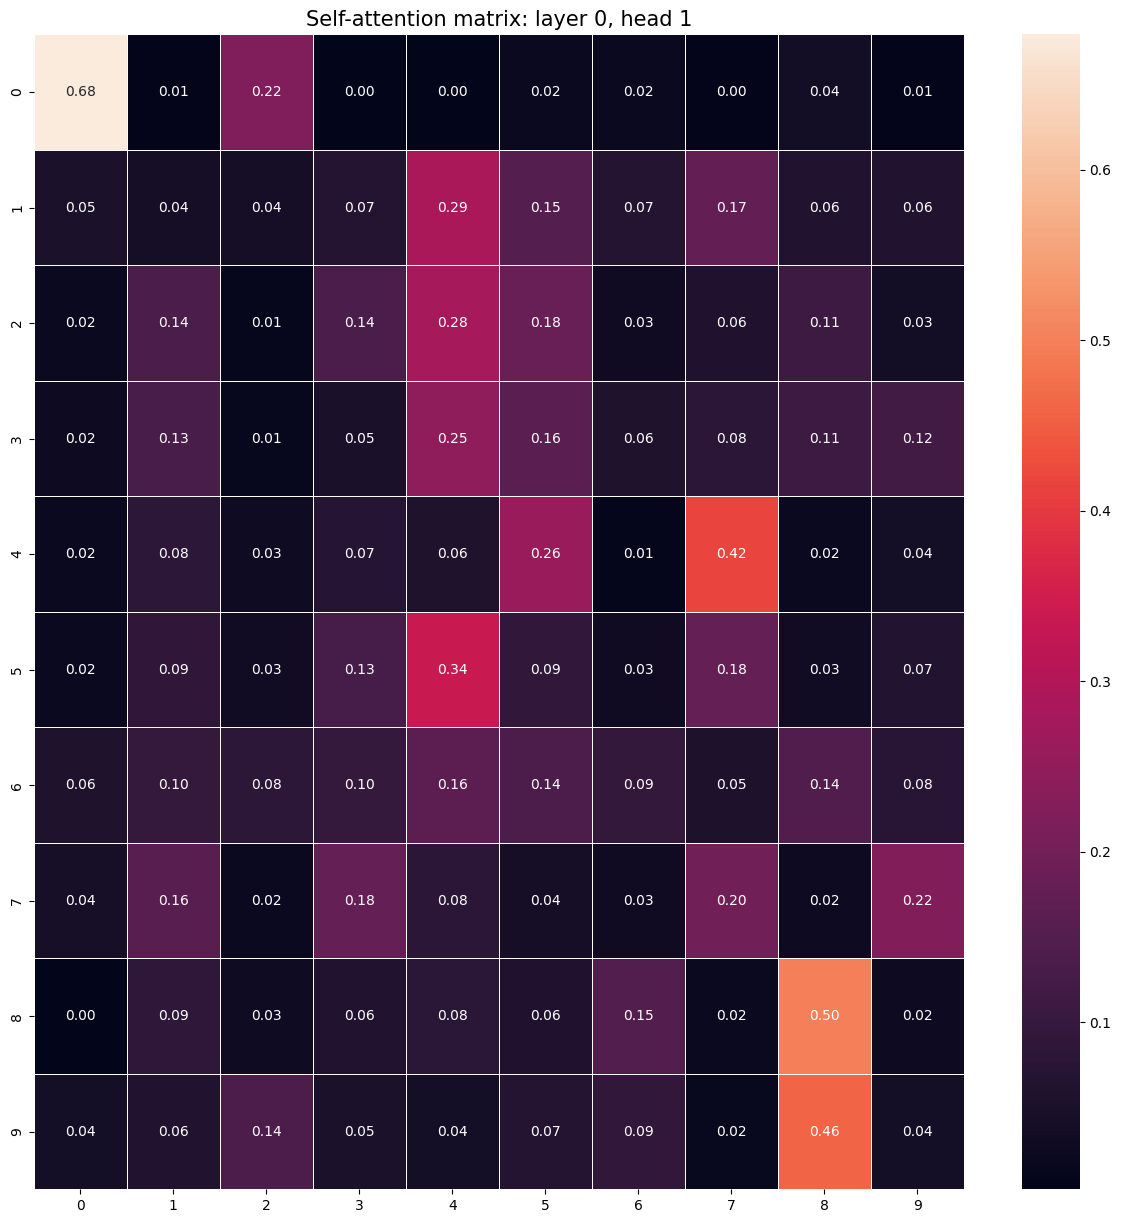

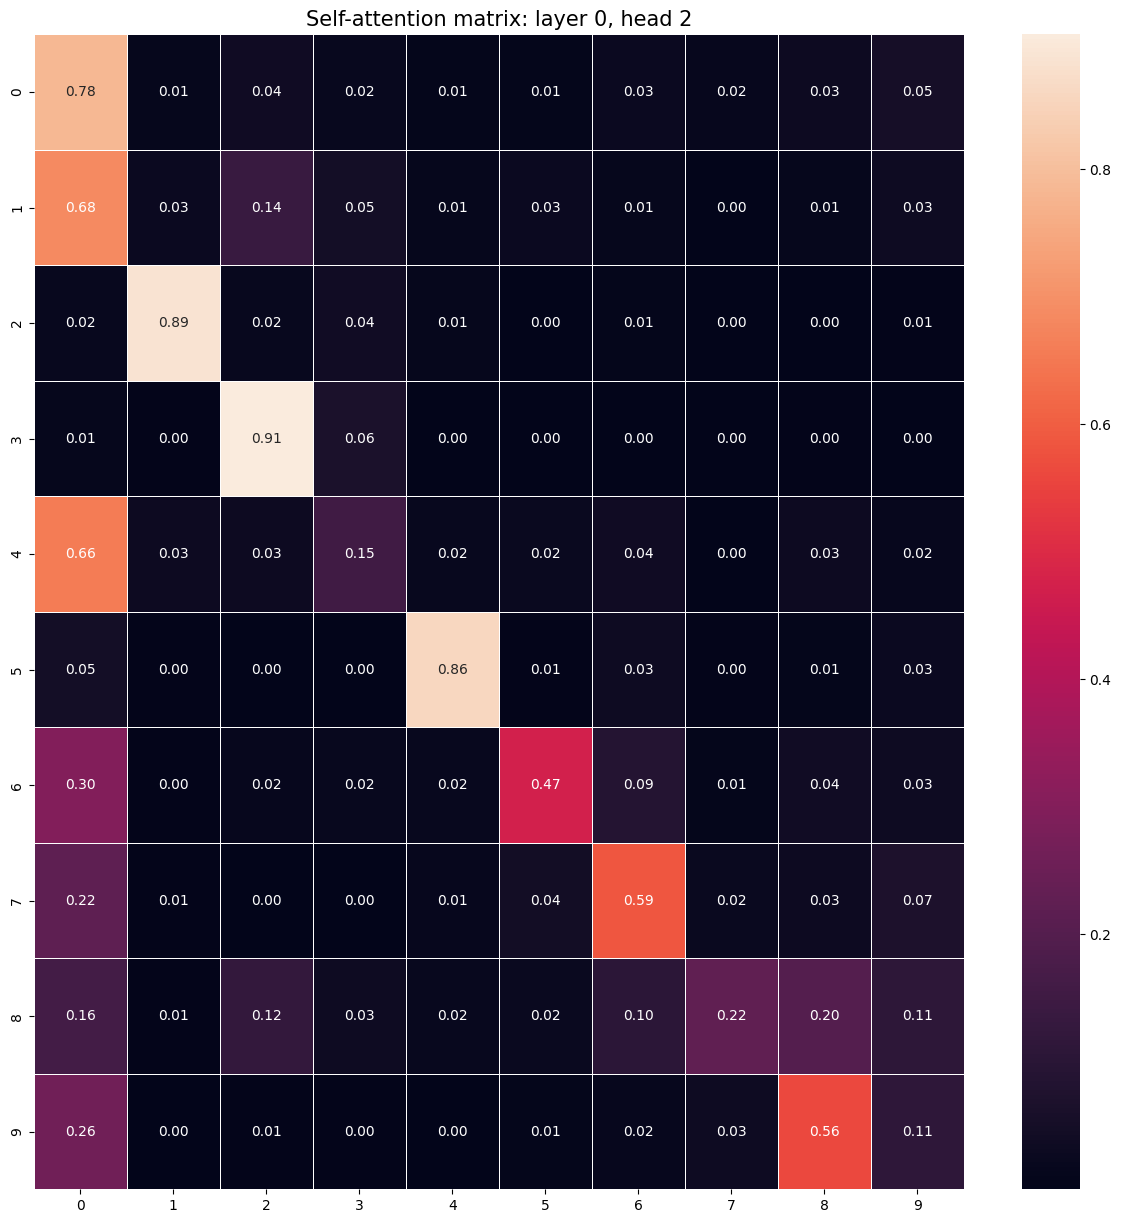

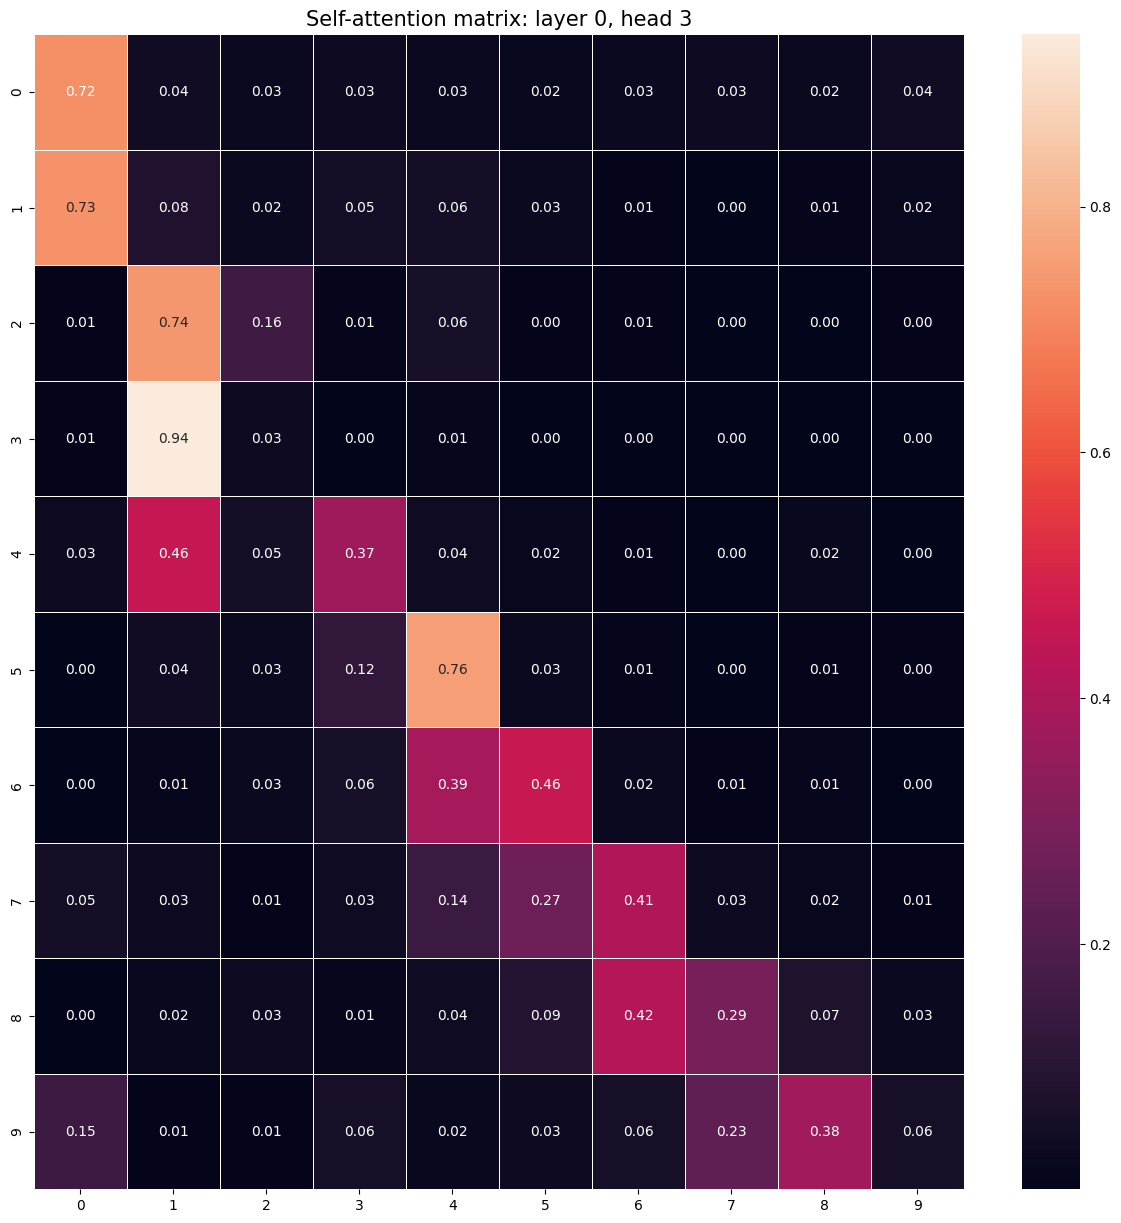

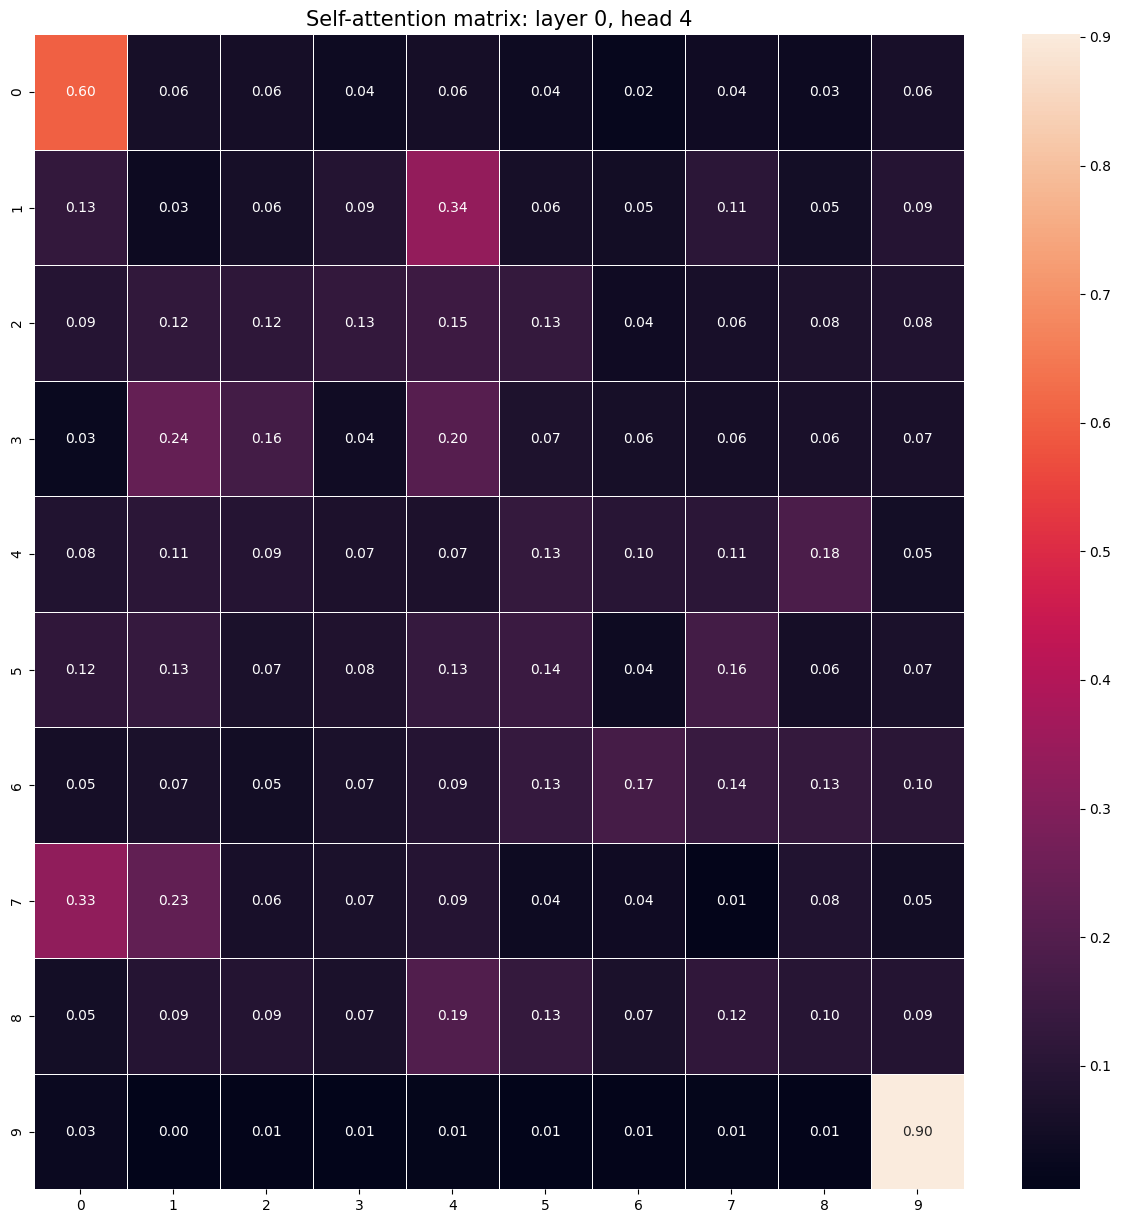

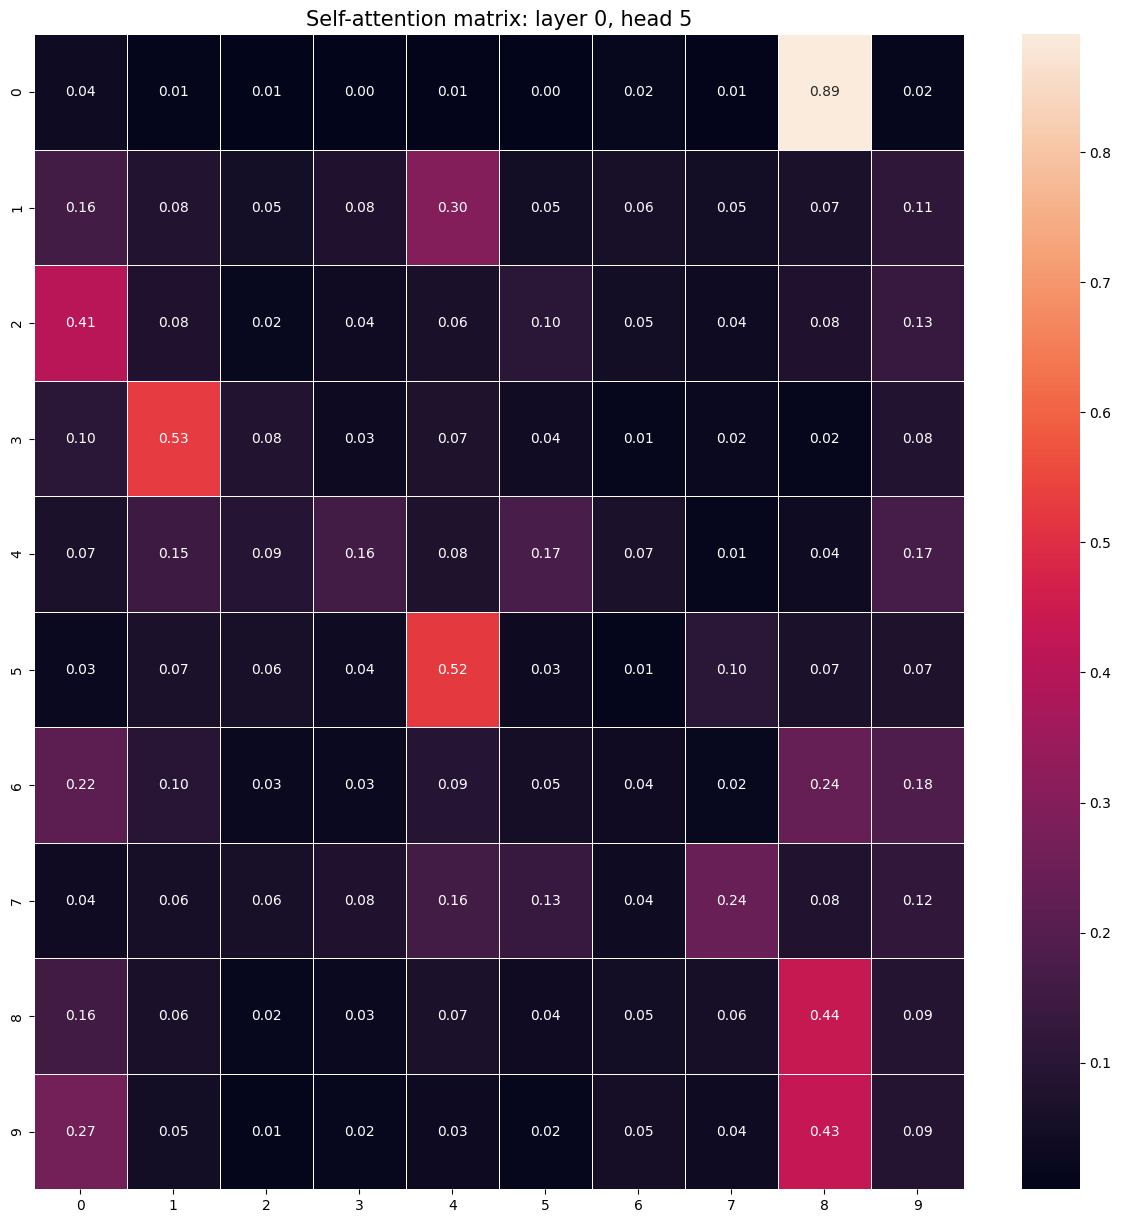

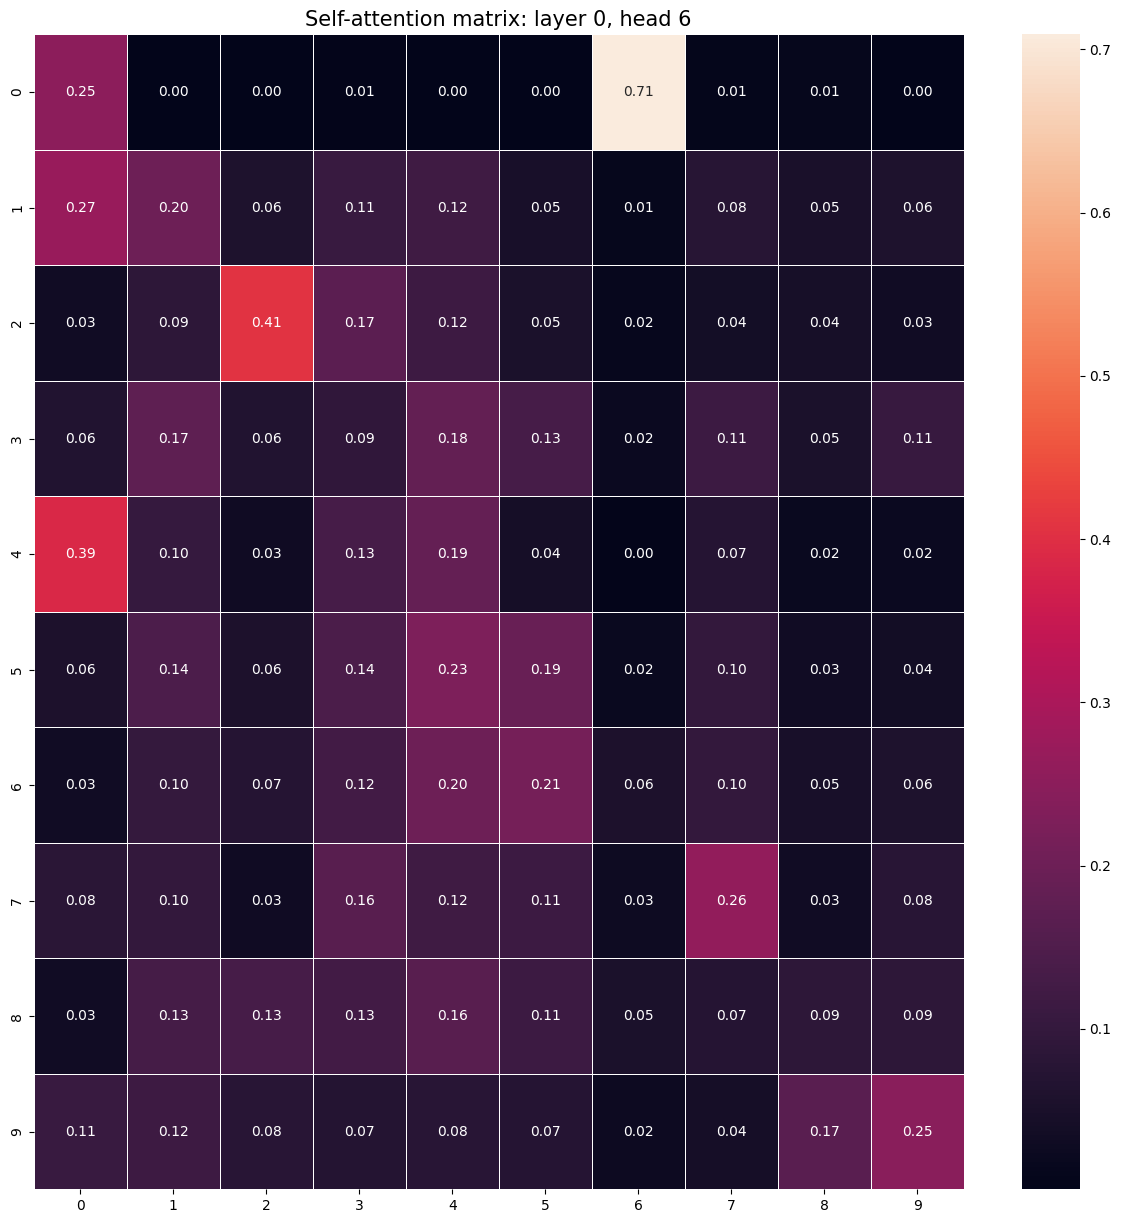

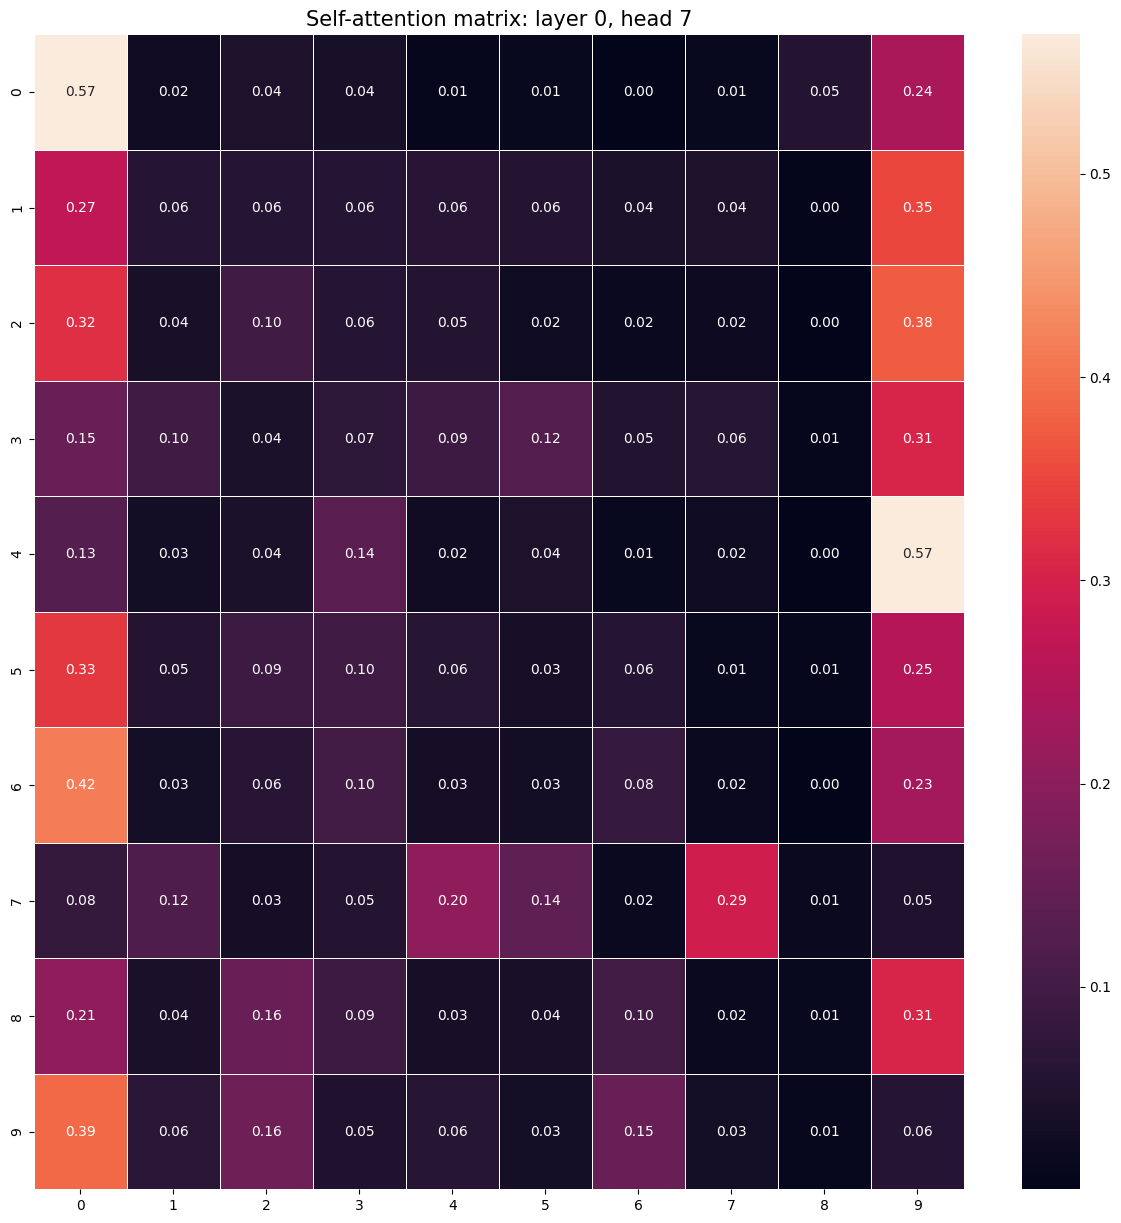

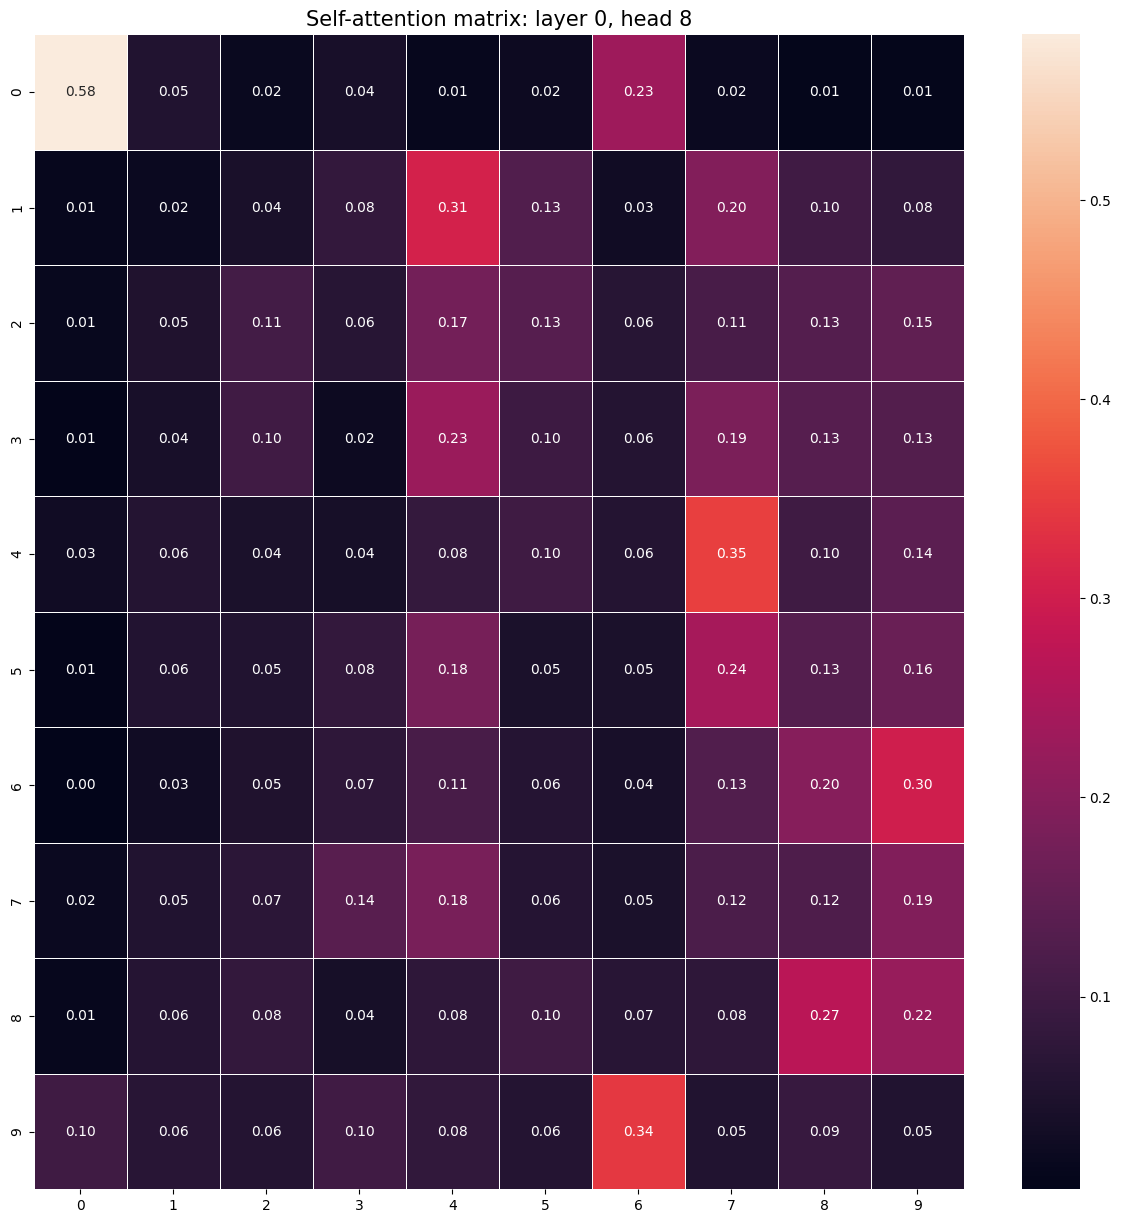

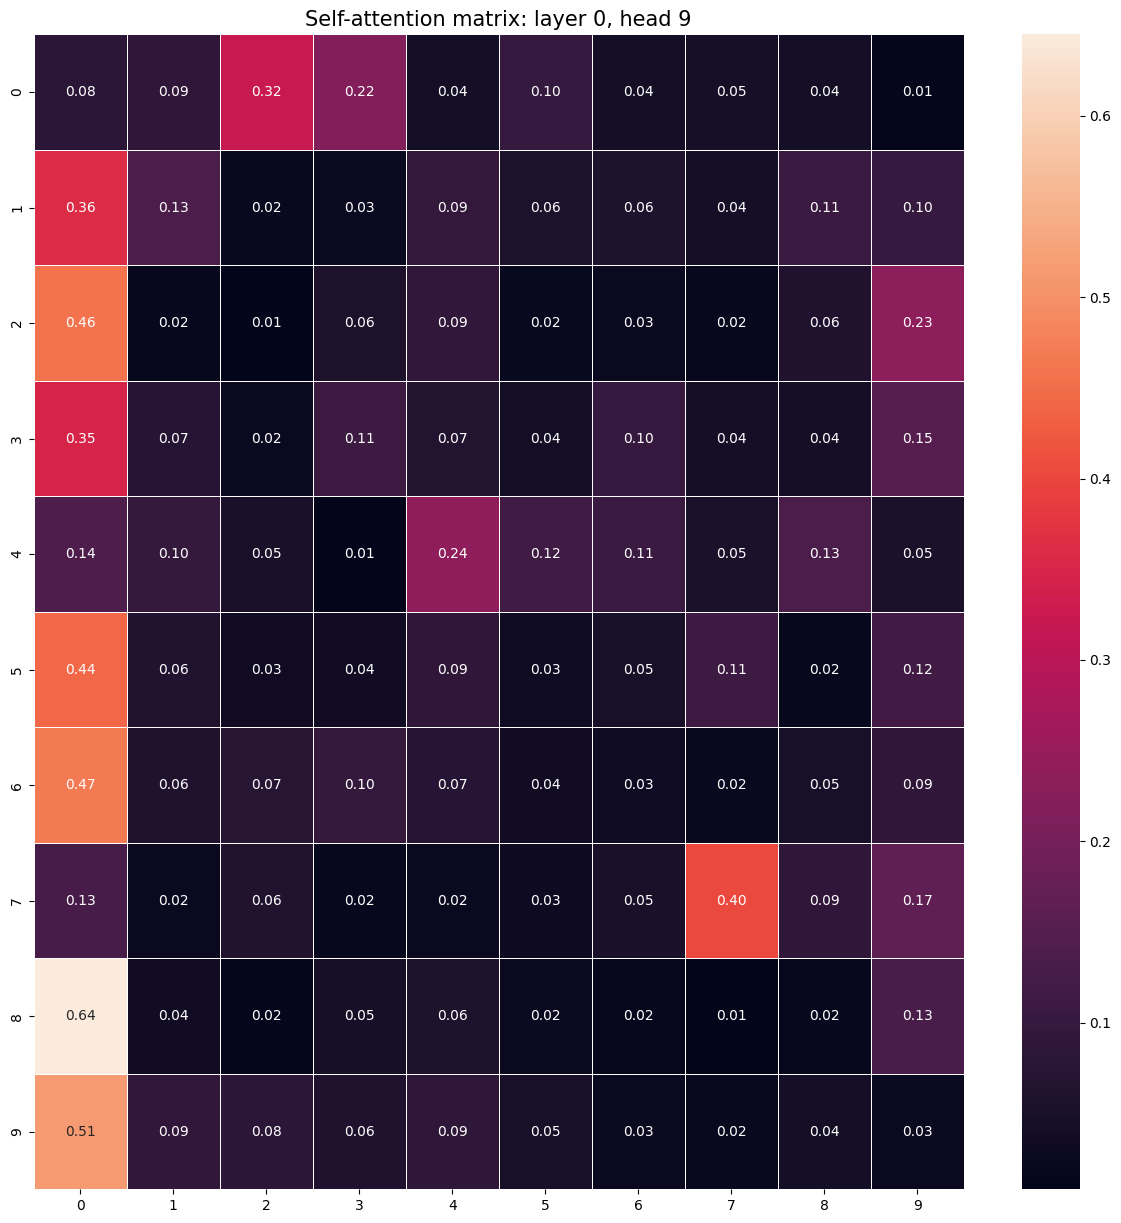

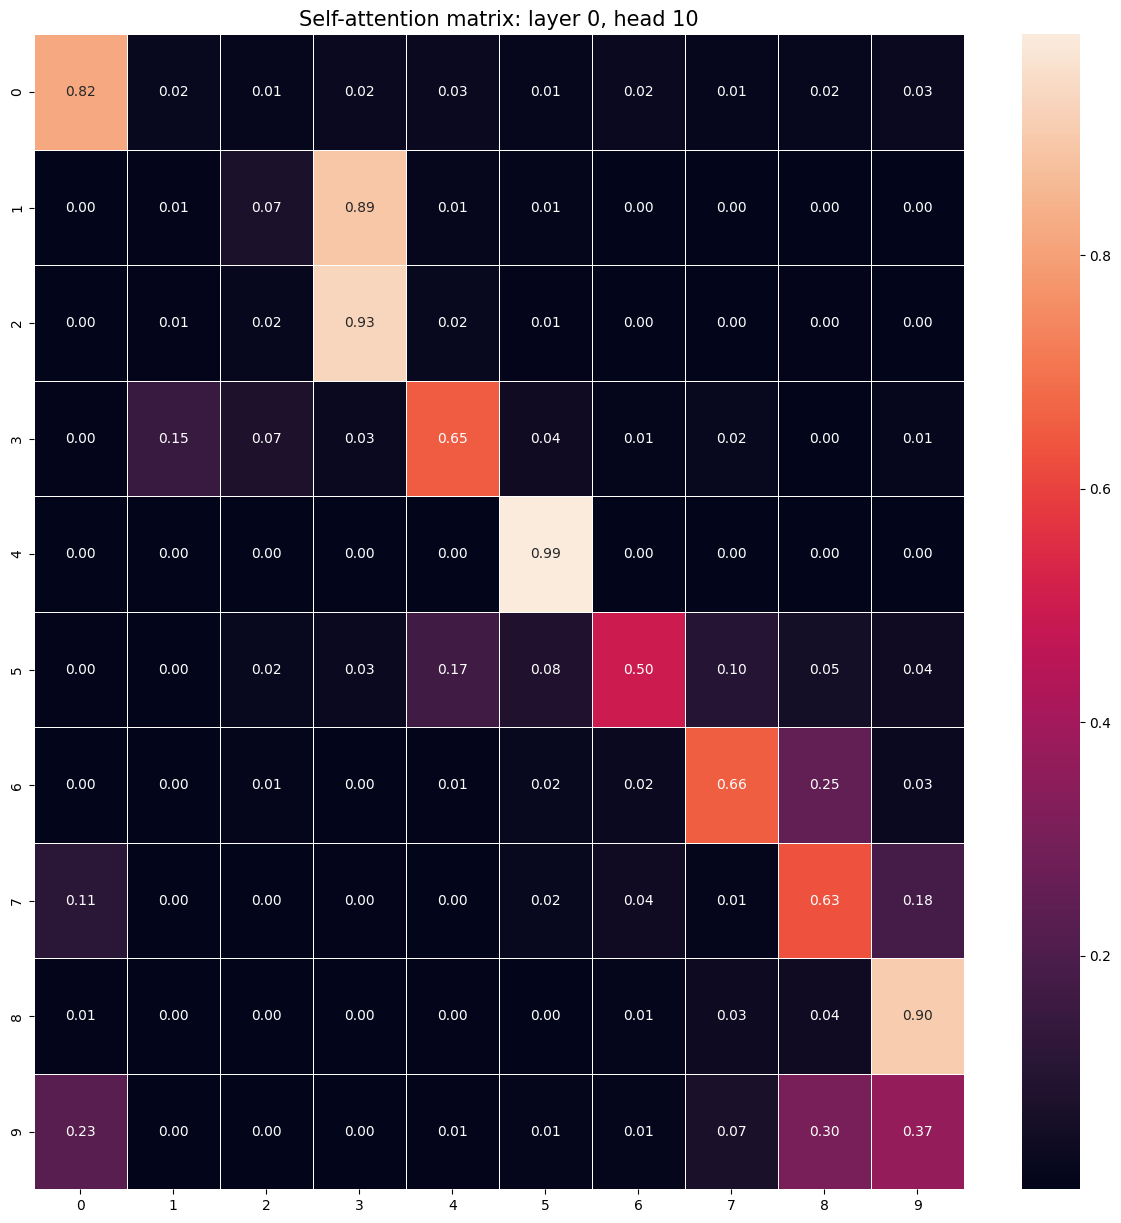

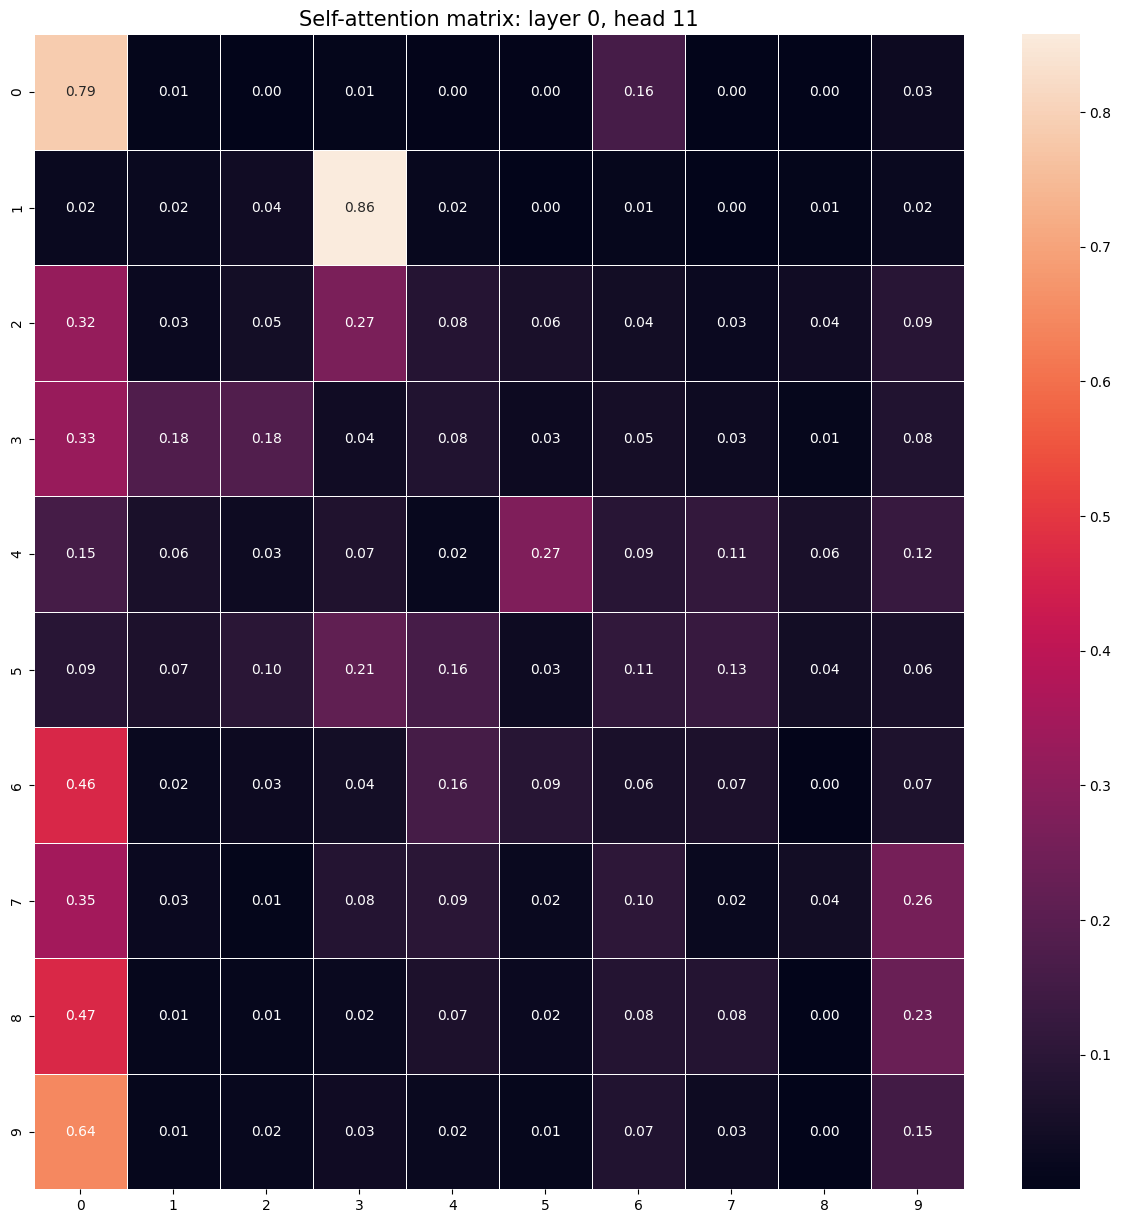

In [221]:
#for layer in range(12):
layer = 0
for head in range(12):
    head_scores = attention_matrix[layer][0][head].cpu().detach().numpy() # First head
    plt.figure(figsize=(15, 15))
    sns.heatmap(
        head_scores,
        linewidth=0.5,
        #xticklabels=labels,
        #yticklabels=labels,
        annot=True,
        fmt='.2f',
    )
    plt.title(f'Self-attention matrix: layer {layer}, head {head}', fontsize=15)
    plt.show()